## Порядковая логистическая регрессионная модель зависимости итогового занятого в турнирной таблице места команды от набранных очков в Английской Премьер-Лиге. 

Множество мест в турнирной таблице соответствует множеству категорий, к одной из которых следует отнести наблюдение. Модель содержит одну независимую переменную - количество очков.

Куммулятивная вероятность быть в категории i или ниже:
$$P(y\leq i) = \sigma(\alpha_i - \beta_1x).$$

В качестве функции, применяемой к линейной функции, берётся логистическая функция: $$\sigma(\alpha_i - \beta_1x) = \frac{e^{(\alpha_i - \beta_1x)}}{1 + e^{(\alpha_i - \beta_1x))}}.$$

Тогда для категорий 1 < 2 < ... < N: $$P(y=1) = P(y\leq 1);$$

$$P(y = i) = P(y\leq i) - P(y\leq (i-1)), [i < N];$$

$$P(y = N) = 1 - P(y\leq N).$$

Модель строится на основе сезонов АПЛ с двадцатью командами с сезона 1995/1996 по сезон 2020/2021.
Используется OrderedLogit из библиотеки bevel https://github.com/Shopify/bevel.

Для удобства интерпертации результатов построения модели, она строится на независимой переменной "инвертированной позиции". То есть, команда, занявшая первое место в чемпионате, получает метку 20, второе местое - 19, и так далее.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bevel.linear_ordinal_regression import OrderedLogit
from scipy.stats import shapiro
from scipy.stats import normaltest

sns.set_style('darkgrid')

In [2]:
numOfTeams = 20

df_apl = pd.read_csv('tables_1965_2021.csv')
df_apl = df_apl.head(520)
df_apl['inv_pos'] = numOfTeams + 1 - df_apl['pos']
df_apl

,season,name,pos,team,p,w,d,l,f,a,gd,points,inv_pos
0,2020/2021,Premier League 2020-2021,1,Manchester City,38,27,5,6,83,32,51,86,20
1,2020/2021,Premier League 2020-2021,2,Manchester United,38,21,11,6,73,44,29,74,19
2,2020/2021,Premier League 2020-2021,3,Liverpool,38,20,9,9,68,42,26,69,18
3,2020/2021,Premier League 2020-2021,4,Chelsea,38,19,10,9,58,36,22,67,17
4,2020/2021,Premier League 2020-2021,5,Leicester City,38,20,6,12,68,50,18,66,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,1995/1996,FA Carling Premiership 1995-1996,16,Coventry City,38,8,14,16,42,60,-18,38,5
516,1995/1996,FA Carling Premiership 1995-1996,17,Southampton,38,9,11,18,34,52,-18,38,4
517,1995/1996,FA Carling Premiership 1995-1996,18,Manchester City,38,9,11,18,33,58,-25,38,3
518,1995/1996,FA Carling Premiership 1995-1996,19,Queens Park Rangers,38,9,6,23,38,57,-19,33,2


<AxesSubplot: xlabel='points', ylabel='inv_pos'>

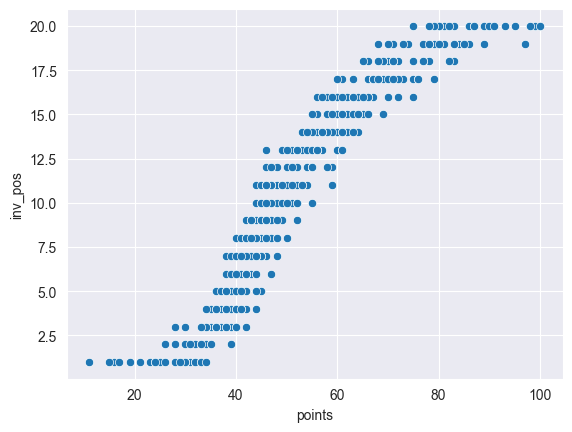

In [3]:
sns.scatterplot(x = 'points', y = 'inv_pos', data = df_apl)

### Гистограмма и KDE распределения набранных очков по каждой позиции в турнирной таблице.
Также для каждого распределения приведены p-value теста на нормальность Шапиро-Уилка. Для всех позиций есть основания принимать нулевую гипотезу о нормальности распределения.

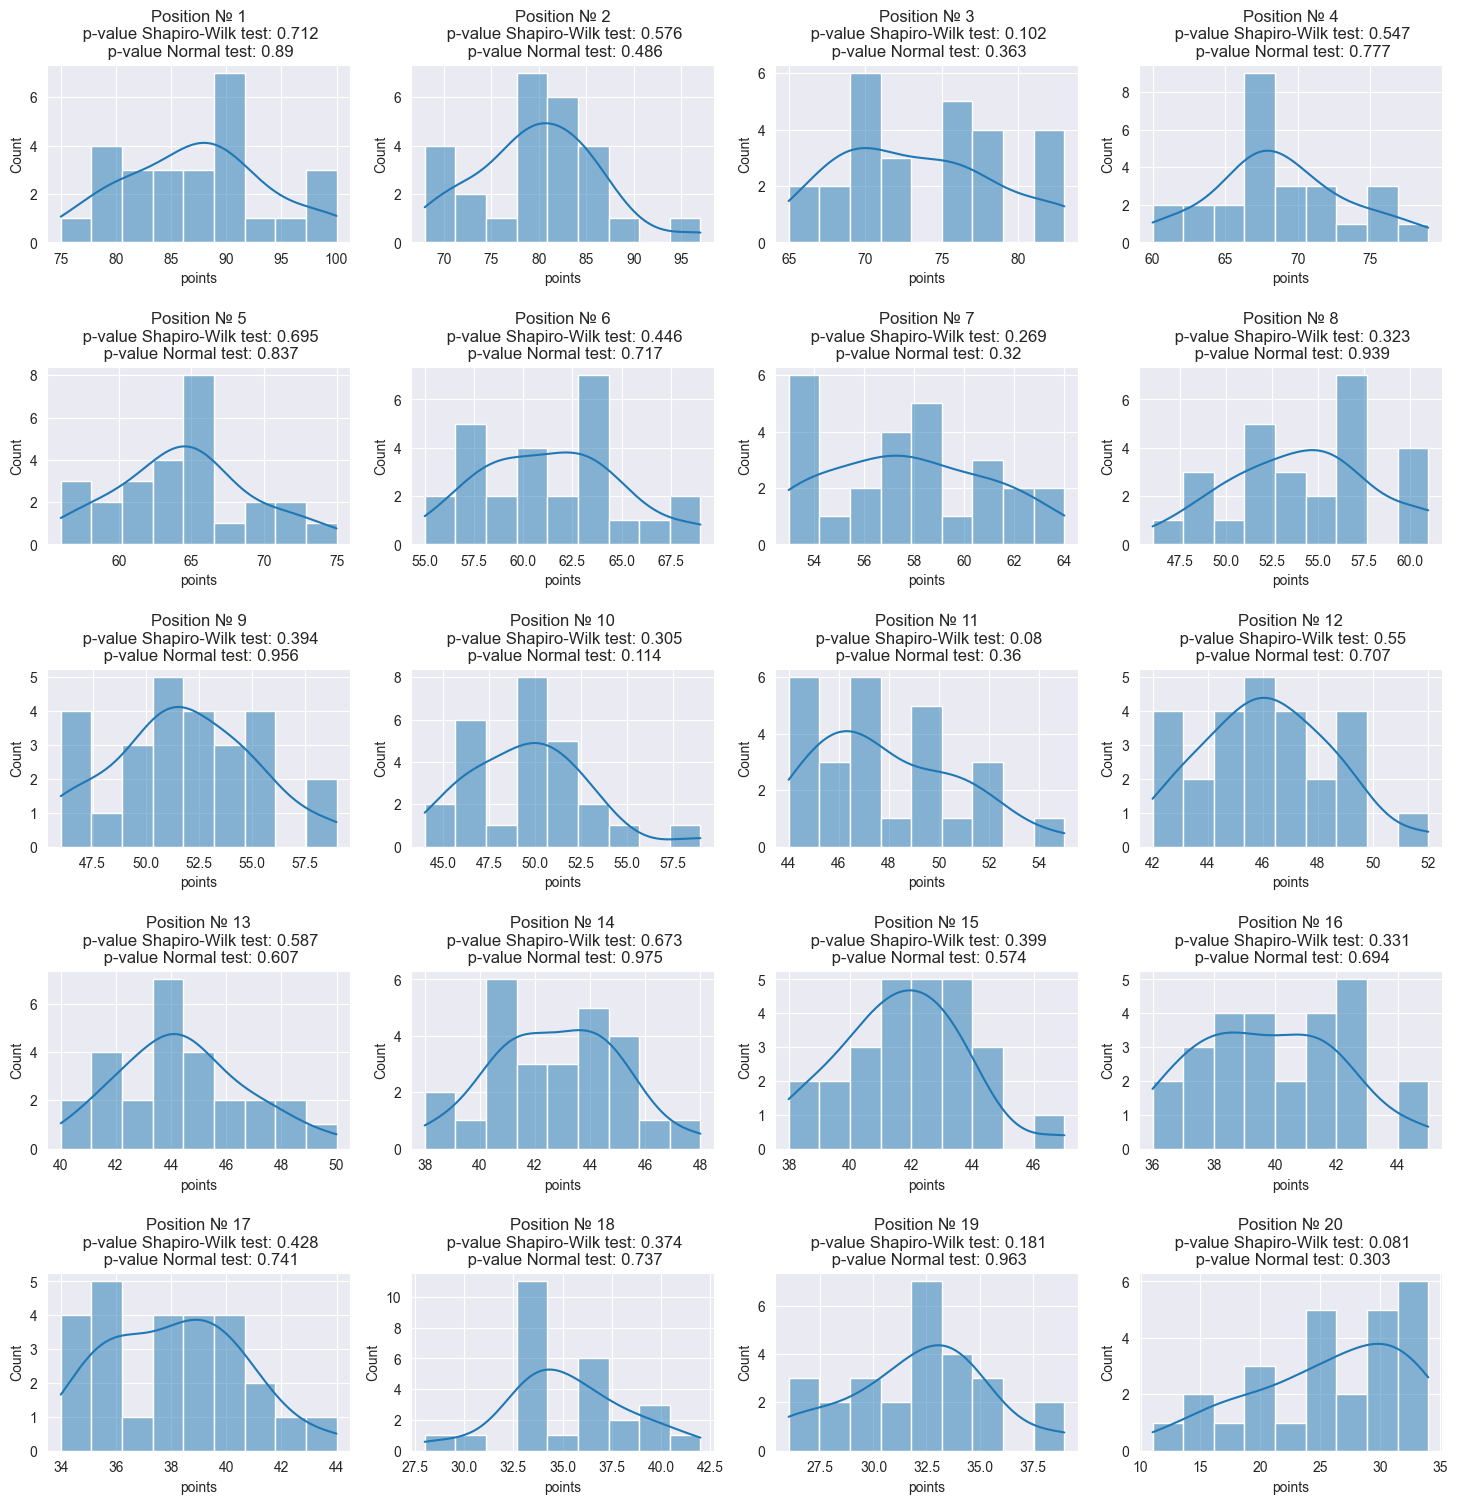

In [4]:
fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize=(18,18))
k = numOfTeams
for i in range(5):
    for j in range(4):
        sns.histplot(data=df_apl[df_apl['inv_pos'] == k], x='points', bins = 9, kde=True, ax = axes[i][j])
        axes[i][j].set_title(f"Position № {21 - k}\n p-value Shapiro-Wilk test: {round(shapiro(df_apl[df_apl['inv_pos'] == k]['points'])[1],3)}\n p-value Normal test: {round(normaltest(df_apl[df_apl['inv_pos'] == k]['points'])[1],3)}")
        k = k - 1
plt.subplots_adjust(hspace=0.7)

### Построение и обучение модели Ordered Logit

In [5]:
df_apl_ol = OrderedLogit()
df_apl_ol.fit(df_apl['points'], df_apl['inv_pos'])
df_apl_ol.print_summary()

n=520
                  beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                     
column_1        0.5138    0.0219 0.0000      0.4709      0.5568  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.896


In [6]:
df_apl_ol.coef_

array([ 0.51381895, 14.79644959, 16.89829513, 18.42069567, 19.62891724,
       20.64957602, 21.56533578, 22.44290396, 23.33924986, 24.26453483,
       25.24344438, 26.31849356, 27.54636891, 29.00691575, 30.66895389,
       32.42438139, 34.36099506, 36.55827035, 39.46817467, 43.02465974])

Первый элемент массива коэффициентов - единый коэффициент бета. Остальные элементы - пороги преодоления категории от 2-й до 20-й.

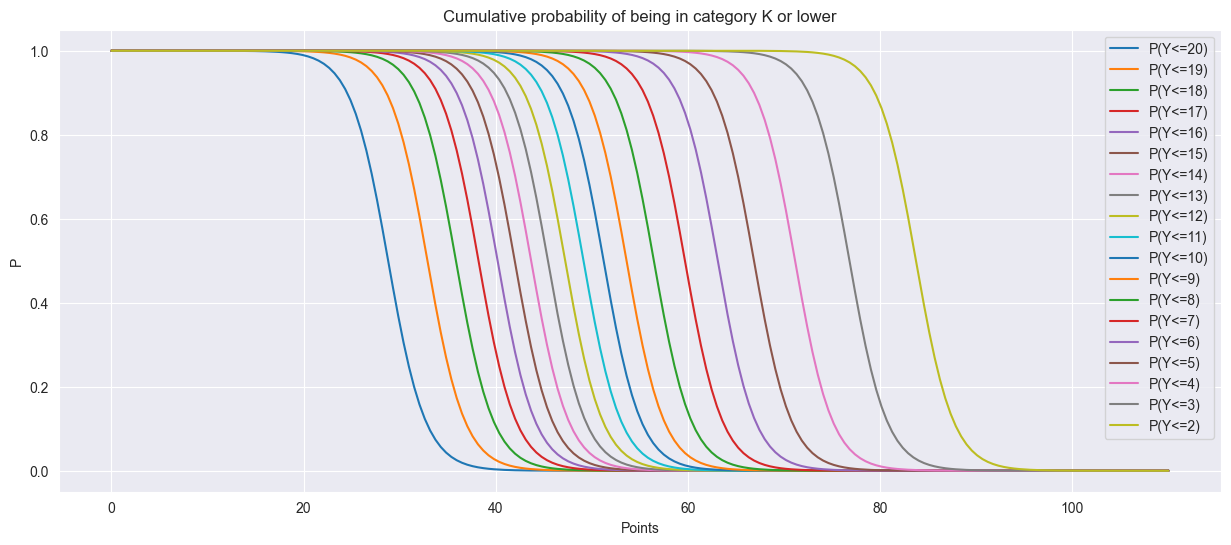

In [7]:
plt.figure(figsize=(15,6))
x = np.linspace(0,110,200)
for i in range(len(df_apl_ol.coef_) - 1):
    plt.plot(x, np.exp(df_apl_ol.coef_[i + 1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[i + 1] - df_apl_ol.coef_[0] * x)), label = f'P(Y<={numOfTeams - i})')
plt.title('Cumulative probability of being in category K or lower')
plt.xlabel('Points')
plt.ylabel('P')
plt.legend()

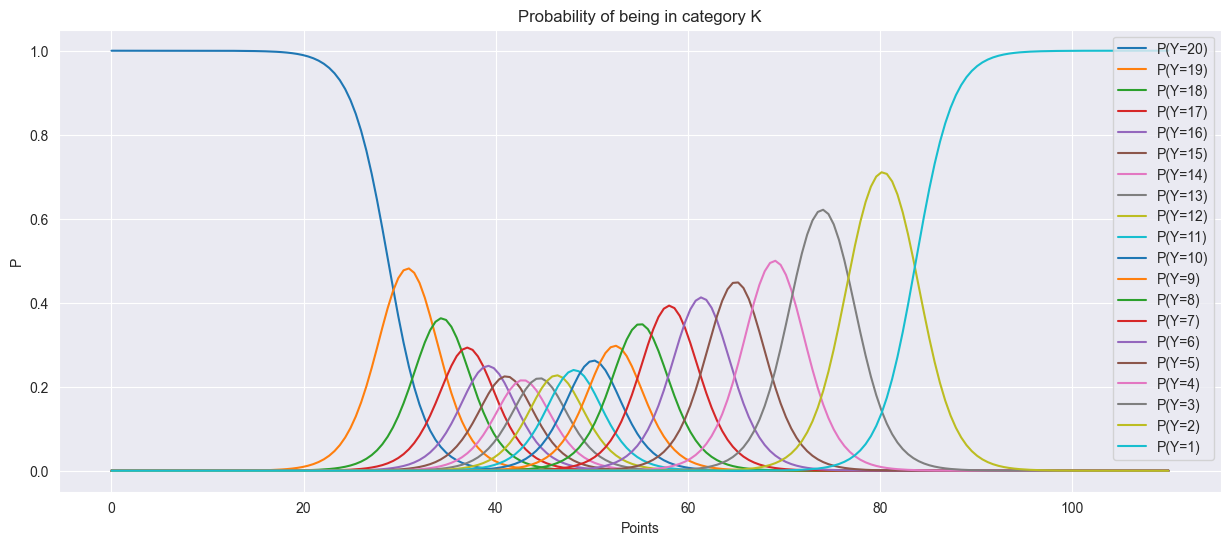

In [8]:
plt.figure(figsize=(15,6))
x = np.linspace(0,110,200)

plt.plot(x, np.exp(df_apl_ol.coef_[1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[1] - df_apl_ol.coef_[0] * x)), label = f'P(Y={numOfTeams})')

for i in range(len(df_apl_ol.coef_) - 2):
    plt.plot(x, np.exp(df_apl_ol.coef_[i + 2] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[i + 2] - df_apl_ol.coef_[0] * x)) - np.exp(df_apl_ol.coef_[i + 1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[i + 1] - df_apl_ol.coef_[0] * x)), label = f'P(Y={numOfTeams - 1 - i})')
plt.plot(x, 1 - np.exp(df_apl_ol.coef_[len(df_apl_ol.coef_) - 1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[len(df_apl_ol.coef_) - 1] - df_apl_ol.coef_[0] * x)), label = f'P(Y=1)')
plt.title('Probability of being in category K')
plt.xlabel('Points')
plt.ylabel('P')
plt.legend()

Фукция выводит вероятность занять каждое место с полученным количеством очков.

In [9]:
def positionProbability(x):
    posProb_dict = {}

    posProb_dict[f'{numOfTeams}'] = round(np.exp(df_apl_ol.coef_[1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[1] - df_apl_ol.coef_[0] * x)), 3)
    for i in range(len(df_apl_ol.coef_) - 2):
        posProb_dict[f'{numOfTeams - 1 - i}'] = round(np.exp(df_apl_ol.coef_[i + 2] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[i + 2] - df_apl_ol.coef_[0] * x)) - np.exp(df_apl_ol.coef_[i + 1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[i + 1] - df_apl_ol.coef_[0] * x)), 3)
    posProb_dict['1'] = round(1 - np.exp(df_apl_ol.coef_[len(df_apl_ol.coef_) - 1] - df_apl_ol.coef_[0] * x) / (1 + np.exp(df_apl_ol.coef_[len(df_apl_ol.coef_) - 1] - df_apl_ol.coef_[0] * x)), 3)

    posProb_dict = dict(sorted(posProb_dict.items(), key = lambda x: x[1], reverse = True))

    keys = list(posProb_dict.keys())
    
    for i in range(len(keys)):
        print('Probability of POSITION', keys[i], ': ', posProb_dict[keys[i]])    

In [10]:
positionProbability(60)

Probability of POSITION 6 :  0.371
Probability of POSITION 7 :  0.321
Probability of POSITION 5 :  0.14
Probability of POSITION 8 :  0.103
Probability of POSITION 9 :  0.025
Probability of POSITION 4 :  0.025
Probability of POSITION 10 :  0.007
Probability of POSITION 3 :  0.003
Probability of POSITION 11 :  0.002
Probability of POSITION 12 :  0.001
Probability of POSITION 20 :  0.0
Probability of POSITION 19 :  0.0
Probability of POSITION 18 :  0.0
Probability of POSITION 17 :  0.0
Probability of POSITION 16 :  0.0
Probability of POSITION 15 :  0.0
Probability of POSITION 14 :  0.0
Probability of POSITION 13 :  0.0
Probability of POSITION 2 :  0.0
Probability of POSITION 1 :  0.0
